In [1]:
from sklearn.datasets import fetch_lfw_pairs

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron

#### 1. Loading the paired dataset

In [8]:
lfw_dataset_train = fetch_lfw_pairs(subset='train', resize = 0.4)
lfw_dataset_test = fetch_lfw_pairs(subset='test', resize = 0.4)

In [9]:
X_train = lfw_dataset_train.pairs
y_train = lfw_dataset_train.target

X_test = lfw_dataset_test.pairs
y_test = lfw_dataset_test.target

In [12]:
x_train_1 = X_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = X_train[:, 1]

x_test_1 = X_test[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_test_2 = X_test[:, 1]

In [15]:
x_train_1[0]

array([[0.29542485, 0.29803923, 0.36993468, ..., 0.4810458 , 0.47320268,
        0.47320268],
       [0.28366014, 0.3137255 , 0.41568628, ..., 0.46666667, 0.45490196,
        0.4169935 ],
       [0.29673204, 0.36078432, 0.46797386, ..., 0.45359477, 0.47973856,
        0.4928105 ],
       ...,
       [0.5764706 , 0.6300654 , 0.72287583, ..., 0.6156863 , 0.6130719 ,
        0.7673202 ],
       [0.6392157 , 0.5764706 , 0.67843133, ..., 0.61960787, 0.60915035,
        0.7137255 ],
       [0.6522876 , 0.60915035, 0.62222224, ..., 0.6039216 , 0.6248366 ,
        0.6261438 ]], dtype=float32)

#### 1.1 Flattening of array

In [16]:
def flatten_arr(data):
    arr = []
    for image in data:
        arr.append(image.flatten())
    return np.array(arr)

In [17]:
x_train_1 = flatten_arr(x_train_1)
x_train_2 = flatten_arr(x_train_2)

x_test_1 = flatten_arr(x_test_1)
x_test_2 = flatten_arr(x_test_2)

In [18]:
x_train_1.shape, x_train_2.shape, x_test_1.shape, x_test_2.shape

((2200, 1850), (2200, 1850), (1000, 1850), (1000, 1850))

#### 2. Calculating the Distance between two Image

In [24]:
def distances_as_feature(data1, data2):
    cosine  = []
    euclidean = []
    cityblock = []
    for index, image in enumerate(data1):
        cosine.append(distance.cosine(image, data2[index]))
        euclidean.append(distance.euclidean(image, data2[index]))
        cityblock.append(distance.chebyshev(image, data2[index]))
    return cosine, euclidean, cityblock

x_train_cosine, x_train_euclidean, x_train_cityblock = distances_as_feature(x_train_1, x_train_2)
x_test_cosine, x_test_euclidean, x_test_cityblock = distances_as_feature(x_test_1, x_test_2)

In [34]:
df_train = pd.DataFrame(columns=["cosine_distance", "euclidean_distance", "cityblock", "label"])

df_test = pd.DataFrame(columns=["cosine_distance", "euclidean_distance", "cityblock", "label"])

#### 3. Preparing Train and test data using distance as feature

In [35]:
df_train["cosine_distance"] = list(x_train_cosine)
df_train["euclidean_distance"] = list(x_train_euclidean)
df_train["cityblock"] = list(x_train_cityblock)
df_train["label"] = list(y_train)

In [36]:
df_test["cosine_distance"] = list(x_test_cosine)
df_test["euclidean_distance"] = list(x_test_euclidean)
df_test["cityblock"] = list(x_test_cityblock)
df_test["label"] = list(y_test)

In [37]:
df_train.head()

,cosine_distance,euclidean_distance,cityblock,label
0,0.025061,5.786790,0.585621,1
1,0.062108,11.135009,0.654902,1
2,0.085081,9.693096,0.679739,1
3,0.055324,5.416252,0.597386,1
4,0.092441,9.700433,0.616993,1


In [38]:
df_test.head()

,cosine_distance,euclidean_distance,cityblock,label
0,0.047550,6.882699,0.802614,1
1,0.095570,10.502570,0.864052,1
2,0.064644,8.291607,0.698039,1
3,0.130386,11.196962,0.750327,1
4,0.043618,7.291383,0.520261,1


In [40]:
df_train["label"]

0       1
1       1
2       1
3       1
4       1
       ..
2195    0
2196    0
2197    0
2198    0
2199    0
Name: label, Length: 2200, dtype: int64

In [41]:
# convert True -> 1 and False -> 0
df_train["label"] = df_train["label"].astype(int)
df_test["label"] = df_test["label"].astype(int)

# features = df_train.drop(columns=["label","difference"]).columns.tolist()

x_train = df_train.drop(columns=["label"])
y_train = df_train["label"]
x_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

#### 4. Training and Testing Model

In [45]:
xgb_cl = xgb.XGBClassifier(n_estimators=250,
                             max_depth=8,
                             objective= 'binary:logistic',
                             seed=27)

In [46]:
# Fit
xgb_cl.fit(x_train, y_train)

# Predict
y_pred = xgb_cl.predict(x_test)

# Score
accuracy_score(y_test, y_pred)

0.575

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

target_names = ["Mismatched","Matched" ]


print(classification_report(y_pred, y_test, target_names=target_names))

              precision    recall  f1-score   support

  Mismatched       0.58      0.57      0.58       505
     Matched       0.57      0.58      0.57       495

    accuracy                           0.57      1000
   macro avg       0.57      0.58      0.57      1000
weighted avg       0.58      0.57      0.58      1000



In [47]:
rf_cl = RandomForestClassifier(n_estimators=250, max_depth=8, criterion = "log_loss")
rf_cl.fit(x_train, y_train)
# Predict
y_pred = rf_cl.predict(x_test)

# Score
acc = accuracy_score(y_test, y_pred)
print("Accuracy ", acc)

Accuracy  0.63


In [48]:
from sklearn.metrics import confusion_matrix, classification_report

target_names = ["Mismatched","Matched" ]


print(classification_report(y_pred, y_test, target_names=target_names))

              precision    recall  f1-score   support

  Mismatched       0.70      0.61      0.65       572
     Matched       0.56      0.65      0.60       428

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.64      0.63      0.63      1000



In [49]:
from sklearn.linear_model import LogisticRegression

lr_cl = LogisticRegression()
lr_cl.fit(x_train, y_train)

y_pred = lr_cl.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.63


In [50]:
from sklearn.metrics import confusion_matrix, classification_report

target_names = ["Mismatched","Matched" ]


print(classification_report(y_pred, y_test, target_names=target_names))

              precision    recall  f1-score   support

  Mismatched       0.61      0.64      0.62       478
     Matched       0.65      0.62      0.64       522

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000



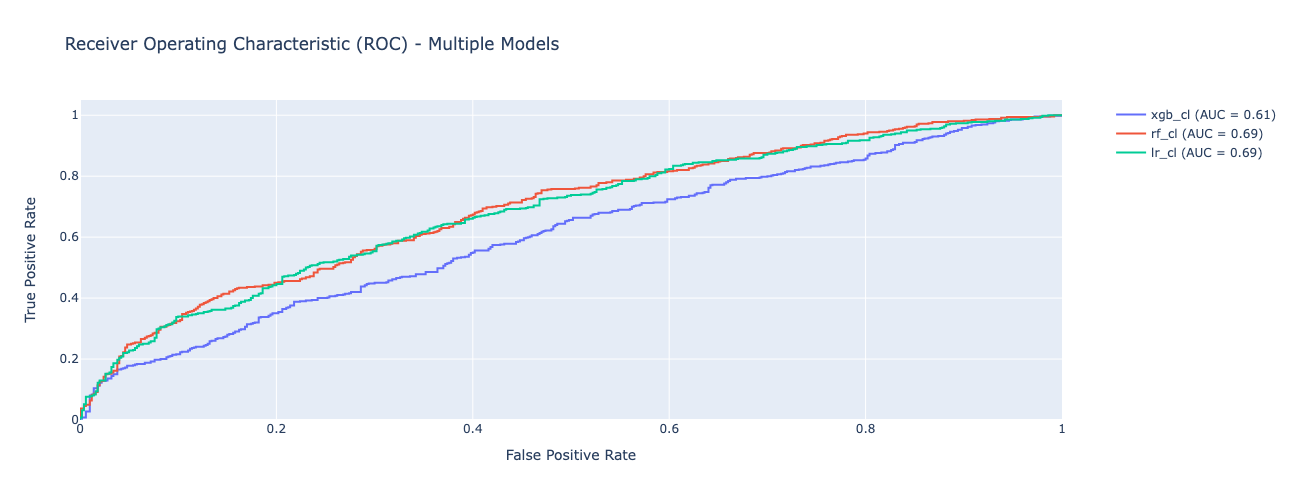

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

# Define classifiers
classifiers = [
    ("xgb_cl", xgb_cl),
    ("rf_cl", rf_cl),
    ("lr_cl", lr_cl)
]

# Create traces for each ROC curve
roc_traces = []
for name, classifier in classifiers:
    y_pred_prob = classifier.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    roc_trace = go.Scatter(x=fpr, y=tpr, mode='lines', name='%s (AUC = %0.2f)' % (name, roc_auc))
    roc_traces.append(roc_trace)

# Create layout
layout = go.Layout(
    title='Receiver Operating Characteristic (ROC) - Multiple Models',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    xaxis_range=[0.0, 1.0],
    yaxis_range=[0.0, 1.05],
    legend=dict(x=1.05, y=1.0, orientation='v'),
    showlegend=True,
    width=1200,
    height=500
)

# Create figure
fig = go.Figure(data=roc_traces, layout=layout)

# Show the plot
fig.show()